In [1]:
# !git clone https://github.com/CamiloMartinezM/ultralytics.git
# %cd /content/ultralytics
# !pip install -e .
# !pip install roboflow
# !pip install -U transformers
# !pip install datasets
# !pip install wandb
# !pip install accelerate -U
# !pip install python-dotenv
# %cd /content

In [2]:
import os
import shutil
from datetime import datetime
from gc import collect as garbage_collect
from warnings import warn

import torch
import yaml
from datasets import load_dataset
from dotenv import load_dotenv
from roboflow import Roboflow
from torch.cuda import empty_cache as cuda_empty_cache
from torch.cuda import mem_get_info
from ultralytics import YOLO

load_dotenv()  # load environment variables stored in .env file (e.g., API keys)

# Useful constants
CURRENT_DIR = os.getcwd()
DATASETS_DIR = os.path.join(CURRENT_DIR, "data")
IMAGES_DIR = os.path.join(DATASETS_DIR, "images")

# Useful functions


def clean_cache():
    """Cleans the GPU memory cache."""
    garbage_collect()
    cuda_empty_cache()
    mem_info = mem_get_info()
    print(
        f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB"
        % (mem_info[0] // 1024**2, mem_info[1] // 1024**2)
    )


def safe_save(model: torch.nn.Module, final_model_path: str) -> None:
    """Saves a model to a file, ensuring that the file does not already exist. If it does, it
    renames the existing file."""
    # Ensure the directory exists
    os.makedirs(os.path.dirname(final_model_path), exist_ok=True)

    if os.path.exists(final_model_path):
        # Get current timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H_%M_%S")

        # Split the path into directory, filename, and extension
        directory, filename = os.path.split(final_model_path)
        name, ext = os.path.splitext(filename)

        # Create new filename with timestamp
        new_filename = f"{name}_{timestamp}{ext}"
        new_path = os.path.join(directory, new_filename)

        warn(f"{final_model_path} already exists. Renaming existing file to: {new_filename}")

        # Rename the existing file
        shutil.move(final_model_path, new_path)

    # Save the new model
    model.save(final_model_path)
    print(f"New model saved as: {final_model_path}")


def load_config(config_path: str) -> dict:
    """Loads a YAML config file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


def to_path(*args):
    """Converts a list of strings into a path, from the current directory saved in `CURRENT_DIR`."""
    # If "/" is present in one of the strings, it is separated into a list of strings, such that we
    # use the safe `os.path.join` function.
    path_parts = []
    for arg in args:
        if '/' in arg:
            path_parts.extend(arg.split('/'))
        else:
            path_parts.append(arg)

    return os.path.join(CURRENT_DIR, *path_parts)


def download_from(config: dict) -> None:
    """Downloads a dataset using the loaded `config`. It must have the following structure:

    ```
    data:
        dataset: e.g., "guitar-necks-detector" or "dduka/guitar-chords" # The name of the dataset
        load:
            interface: "roboflow" or "datasets"
            # (These must be available only if interface is "roboflow":)
            workspace: "..."
            project-version: "1"
            version-download: "..."
    ```
    """
    if config["data"]["load"]["interface"] == "roboflow":
        # Test if a ROBOFLOW_API_KEY is available
        if not os.getenv("ROBOFLOW_API_KEY"):
            from importlib.util import find_spec

            if find_spec("google"):
                from google.colab import userdata
                if userdata.get("ROBOFLOW_API_KEY"):
                    os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
            else:
                raise ValueError(
                    "ROBOFLOW_API_KEY is not available in the environment variables. "
                    + "Create a .env file in this directory with the key or in Google "
                    + "Colab, add it to secret keys."
                )

        # Initialize Roboflow
        rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))

        # Access the workspace and project
        project = rf.workspace(config["data"]["load"]["workspace"]).project(
            config["data"]["dataset"]
        )
        version = project.version(config["data"]["load"]["project-version"])
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = version.download(config["data"]["load"]["version-download"], location=dataset_path)
    elif config["data"]["load"]["interface"] == "datasets":
        dataset_path = os.path.join(DATASETS_DIR, config["data"]["dataset"])
        ds = load_dataset(config["data"]["dataset"], cache_dir=dataset_path)

    return ds, dataset_path

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
FINAL_MODELS_DIR = to_path("final_models")
ORIGINAL_MODELS_DIR = to_path("original_models")
IMAGES_DIR = to_path("images")

In [4]:
f_run_config = "config-yolo-v9.yml"

In [5]:
# Load configuration
config = load_config(to_path(f_run_config))

## **Add New `ConcatHead` Layer**

In [6]:
def load_finetuned_yolo_model(model: str, architecture_yaml: str, state_dict_path: str) -> YOLO:
    model = YOLO(architecture_yaml, task="detect").load(model)
    state_dict = torch.load(state_dict_path)
    model.load_state_dict(state_dict, strict=False)
    return model

In [7]:
model = load_finetuned_yolo_model(
    os.path.join(ORIGINAL_MODELS_DIR, "yolov9c.pt"),
    "yolov9c-2xhead.yaml",
    os.path.join(FINAL_MODELS_DIR, "yolov9c_trained_state_dict.pth"),
)

orig_model = YOLO(os.path.join(ORIGINAL_MODELS_DIR, "yolov9c.pt"))

non_frozen_model = YOLO(os.path.join(FINAL_MODELS_DIR, "yolov9c_trained_without_freezing.pt"))

Transferred 937/1022 items from pretrained weights


In [8]:
ncm = model.model.names
print(ncm)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 41: '41', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 60: '60', 61: '61', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80'}


In [9]:
# Get the keys that are not present in the original model
new_keys = set(model.names.keys()) - set(orig_model.names.keys())
old_model_names = model.names.copy()

# Redefine the names dictionary
model.model.names = orig_model.names
for k in new_keys:
    model.model.names[k] = old_model_names[k]

model.model.names[80] = "fretboard"
print(model.model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [10]:
# Output of the new model
result_coco = model.predict(os.path.join(IMAGES_DIR, "test-coco.jpg"))[0]
result_fretboard = model.predict(os.path.join(IMAGES_DIR, "test-fretboard.jpg"))[0]
result_fretboard_non_frozen = non_frozen_model.predict(os.path.join(IMAGES_DIR, "test-fretboard.jpg"), conf=0.70)[0]


image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-coco.jpg: 480x640 3 persons, 1 bus, 1 traffic light, 103.9ms
Speed: 2.5ms preprocess, 103.9ms inference, 104.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-fretboard.jpg: 384x640 1 person, 1 fretboard, 94.8ms
Speed: 2.0ms preprocess, 94.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/images/test-fretboard.jpg: 384x640 1 Guitar-necks, 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


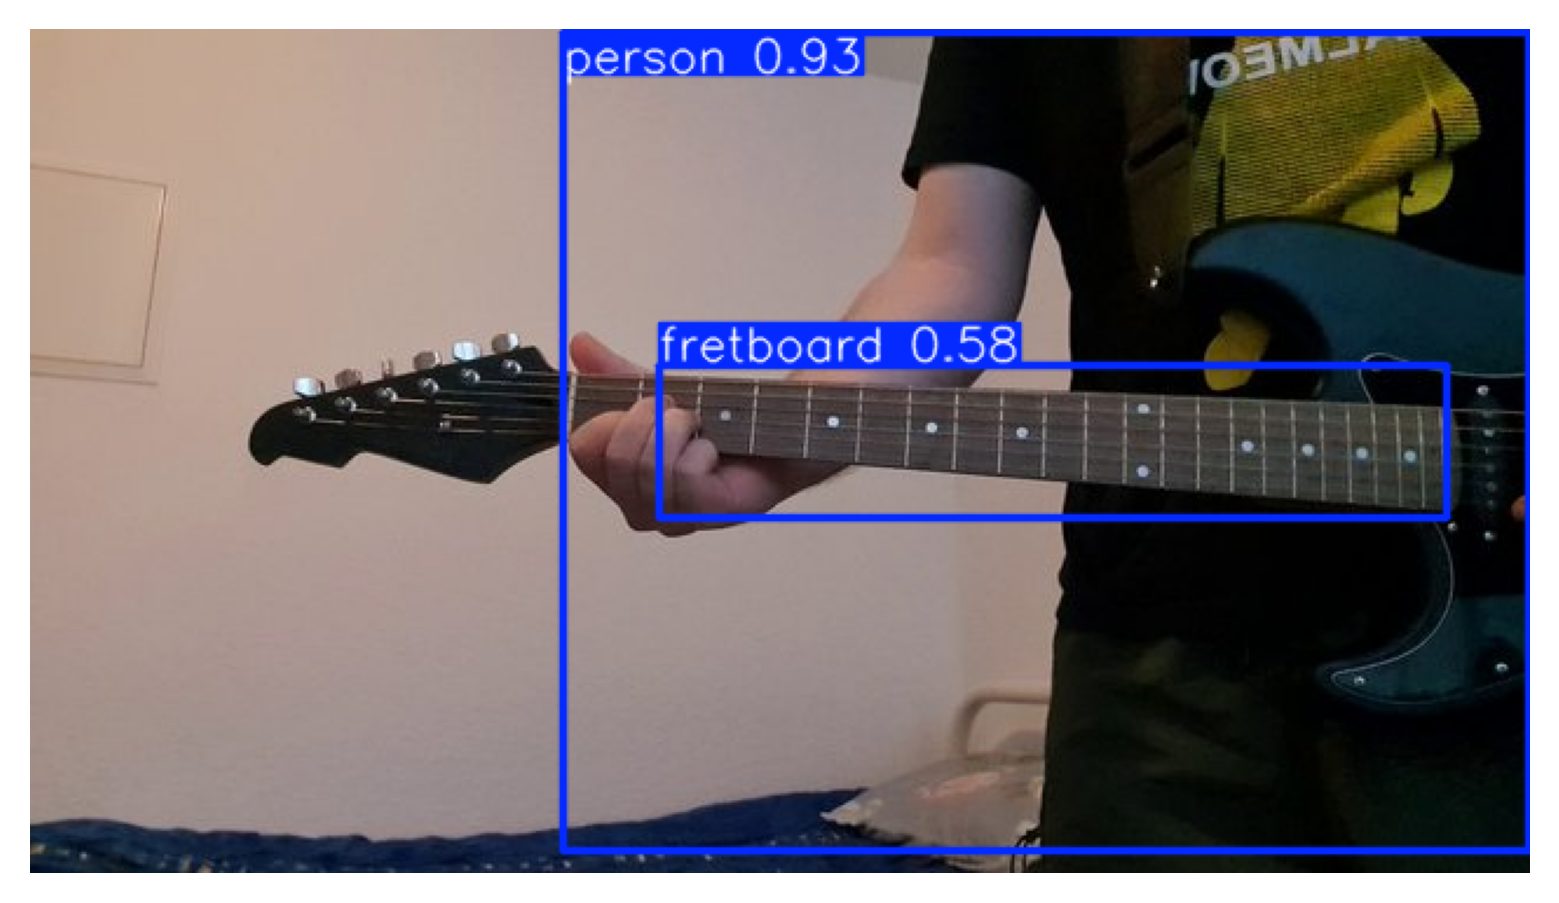

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_output(images):
    image = np.vstack(images)
    fig = plt.figure(dpi=300)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.set_size_inches((5,15))
    ax.imshow(image[...,::-1])
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGES_DIR, "output.jpg"), bbox_inches="tight", pad_inches=0, dpi=300)
    plt.show()
    plt.close()

# show_output([result_coco.plot(), result_fretboard.plot()])
show_output([result_fretboard.plot()])

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


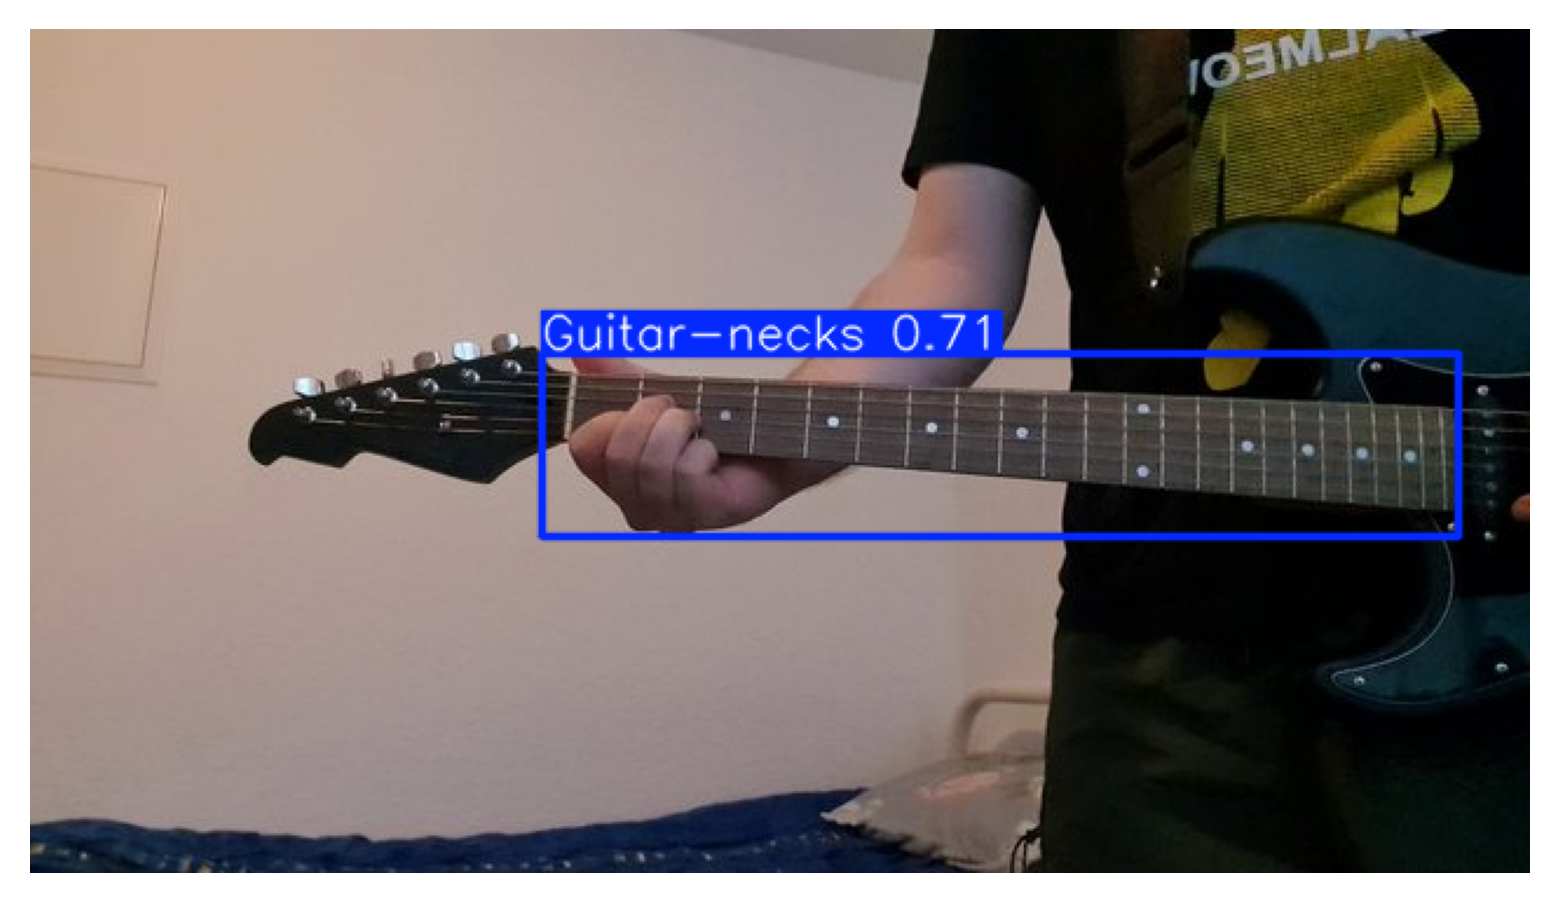

In [12]:
show_output([result_fretboard_non_frozen.plot()])

In [13]:
# safe_save(model, os.path.join(FINAL_MODELS_DIR, "yolov9c_finetuned.pt"))